In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
for dirname, _, filenames in os.walk('Source'):
    for filename in filenames:
        print(dirname + "/" + filename)

Source/data_description.txt
Source/sample_submission.csv
Source/test.csv
Source/train.csv


In [2]:
#Functions for categorizing columns
def categorize_column(series, num_bins):
    bins = pd.cut(series, num_bins, retbins=True)[1]
    return pd.Series(np.digitize(series, bins, right=True))

#Functions for imputing nans
def impute_nans(df, categorical_columns=[], continuous_columns=[]):
    for column in categorical_columns + continuous_columns:
        if column in categorical_columns:
            replacement = df[column].dropna().mode()[0]
        if column in continuous_columns:
            replacement = df[column].dropna().median()
        df[column] = df[column].fillna(replacement)

    return df

In [3]:
original_training=pd.read_csv("Source/train.csv")
original_test=pd.read_csv("Source/test.csv")
training=original_training.copy()
test=original_test.copy()
test["SalePrice"]=0
pd.set_option('display.max_columns', None)
print(training.shape)
print(training.head())

(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            

In [4]:
#Concatenante training and test dataframe
all_data=pd.concat([training,test])

In [5]:
#Identify Nan data
training_nan_sorted=training.isnull().sum().sort_values(ascending=False)

#Drop columns with more than 10% of Nan values.
training_nan_sorted_drop=training_nan_sorted[training_nan_sorted>\
                                             len(training)*0.1]

#Create list of index
training_drop_list=training_nan_sorted_drop.index.tolist()

#Drop columns with too many Nan on both training and test dataframe
training=training.drop(training_drop_list,axis=1)
test=test.drop(training_drop_list,axis=1)


In [6]:
#Split categorical and continuous columns
#pd.set_option('display.max_rows', None)

Cat_List=["GarageType","GarageCond","GarageFinish","GarageQual","BsmtFinType1","BsmtFinType2","BsmtCond","BsmtQual",\
          "BsmtExposure","MasVnrType","Electrical"]
Num_List=["GarageYrBlt","MasVnrArea"]

#Impute Nans
training=impute_nans(training,categorical_columns=Cat_List,continuous_columns=Num_List)


In [7]:
training_col_list=training.columns.tolist()
print(training_col_list)

['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'Sal

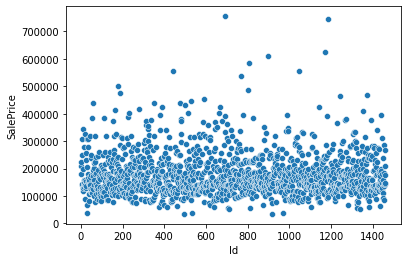

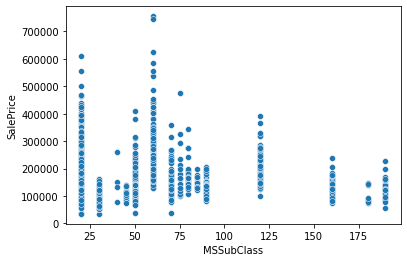

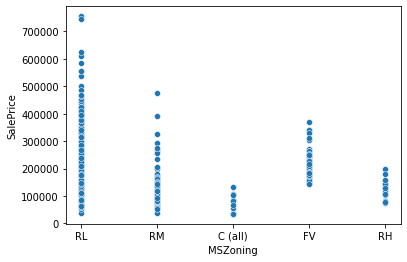

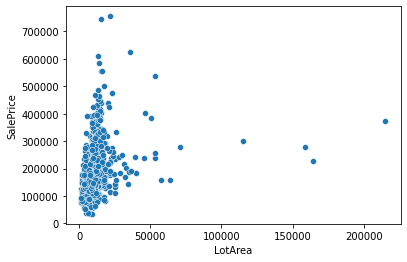

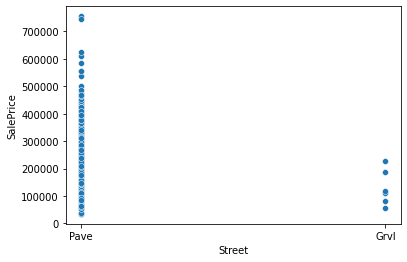

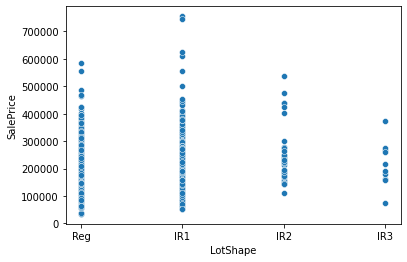

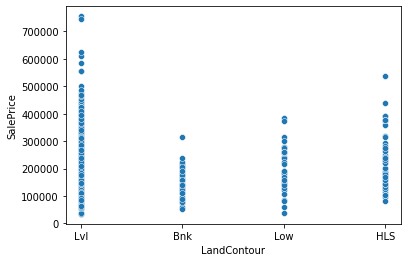

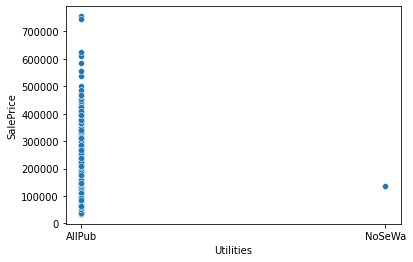

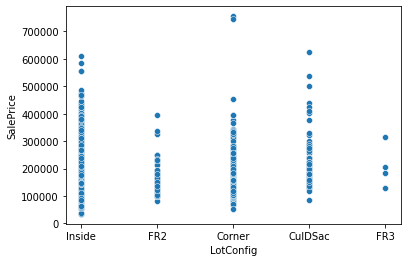

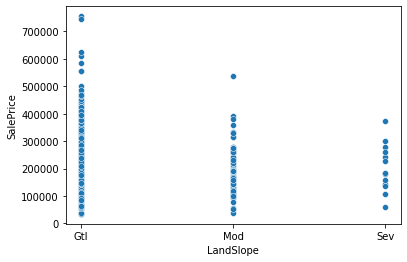

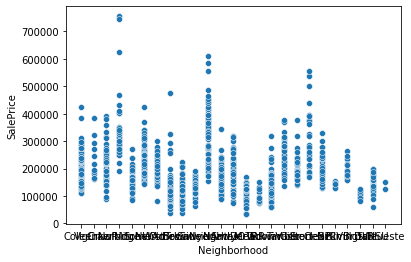

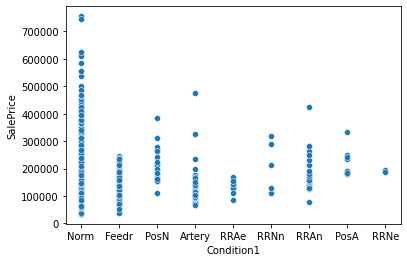

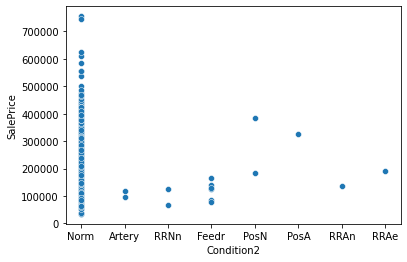

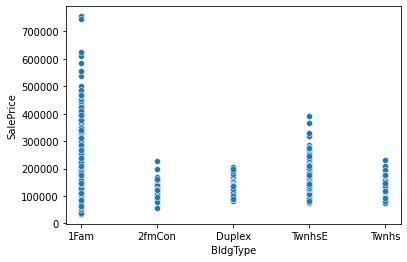

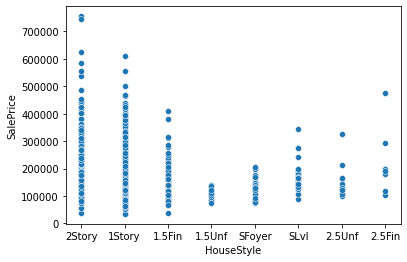

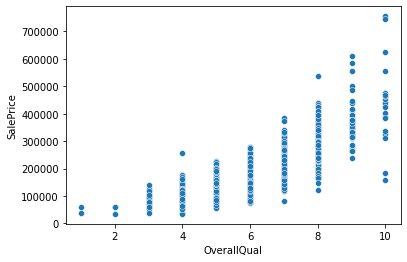

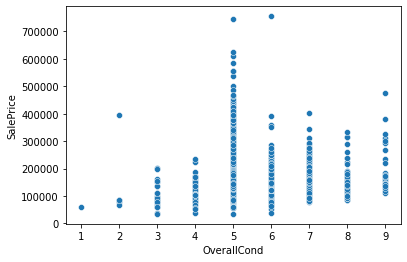

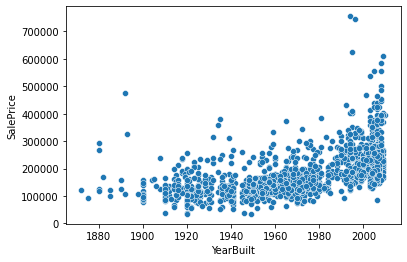

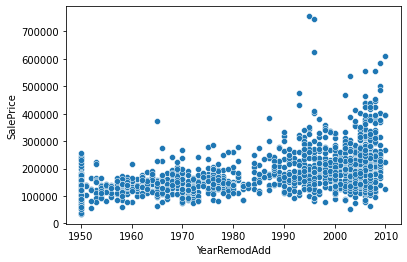

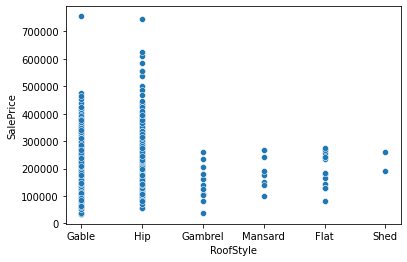

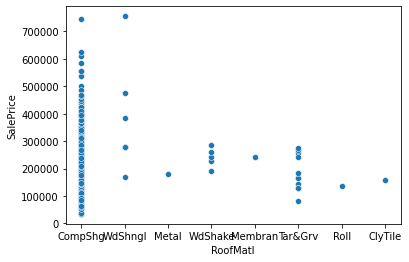

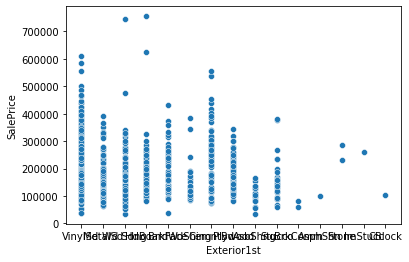

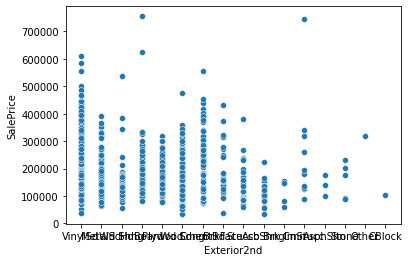

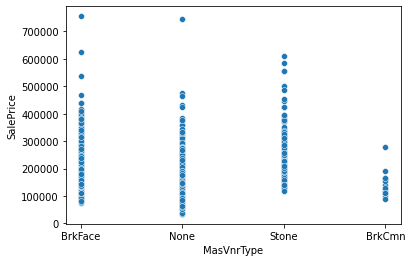

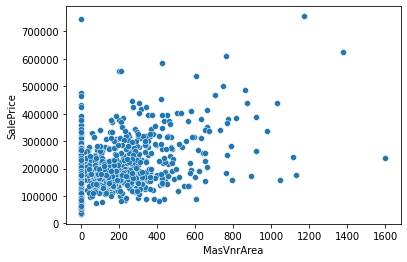

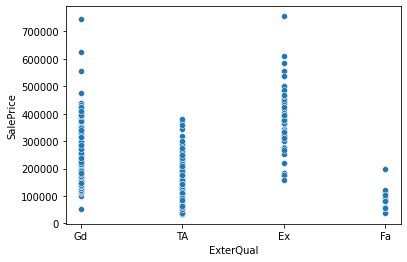

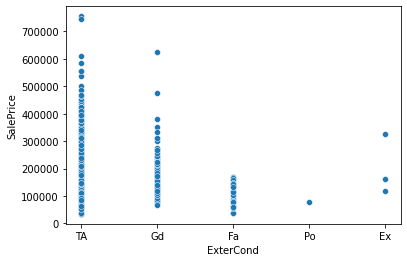

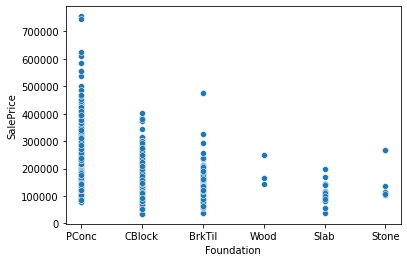

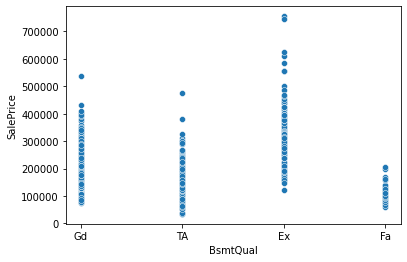

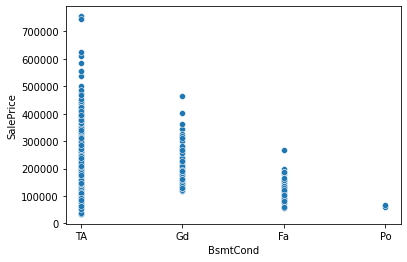

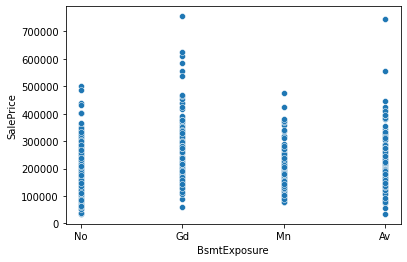

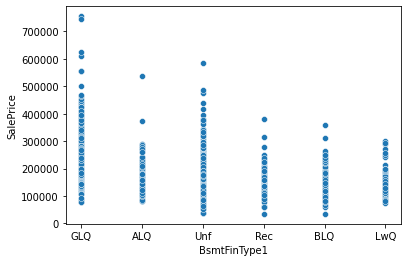

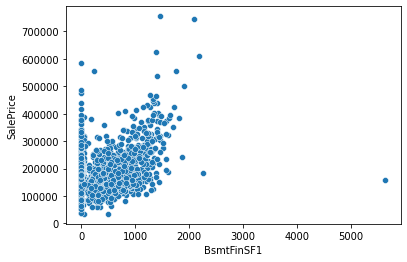

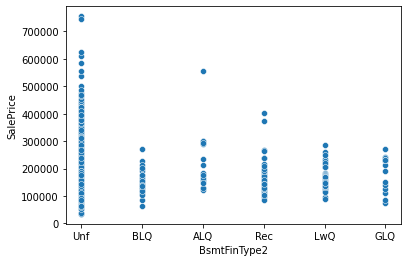

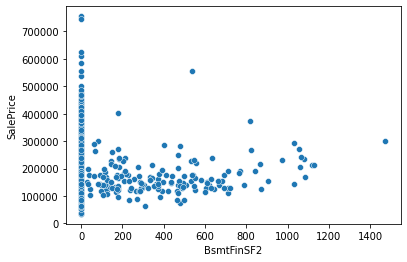

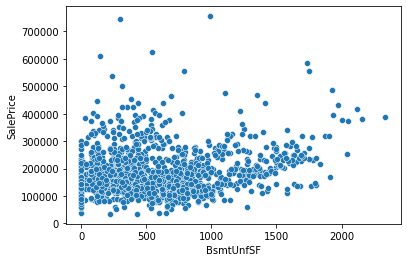

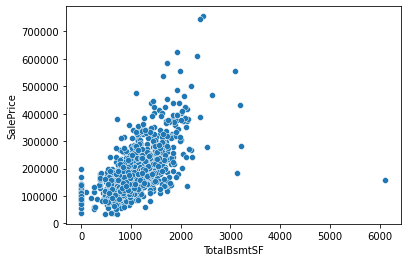

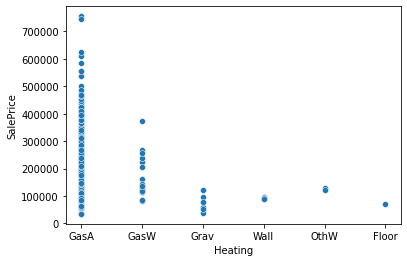

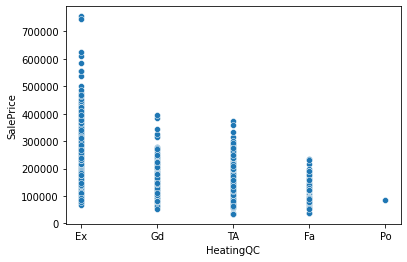

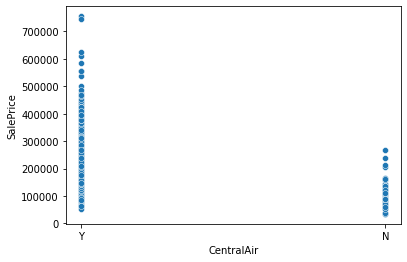

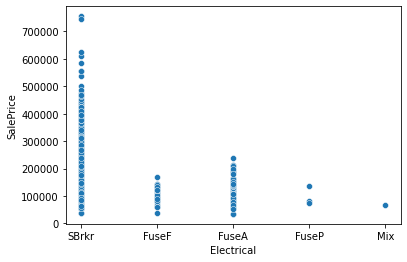

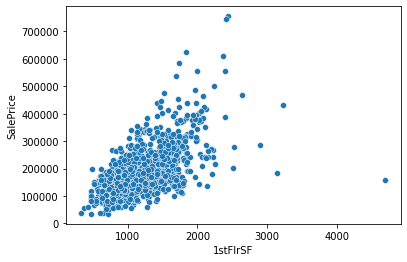

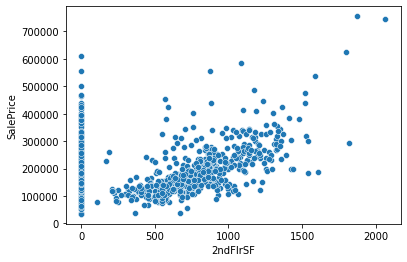

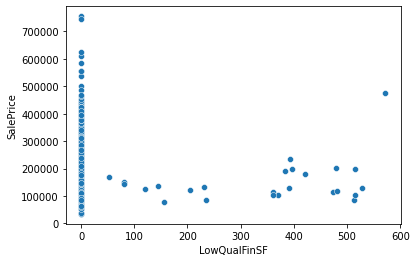

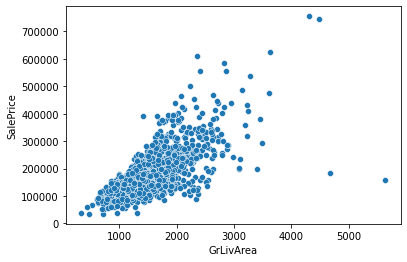

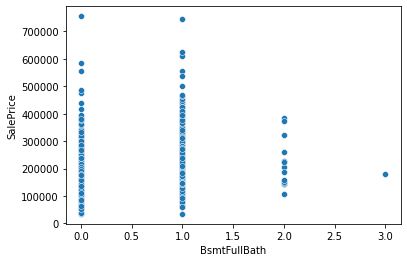

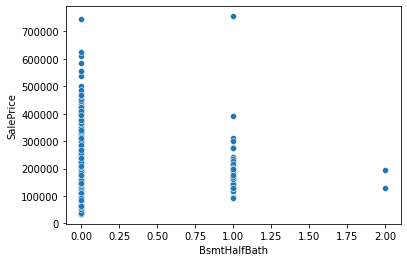

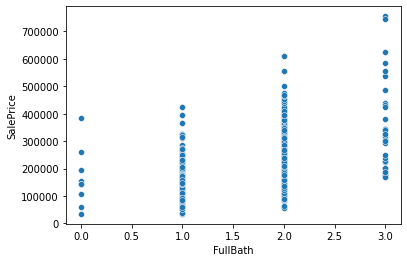

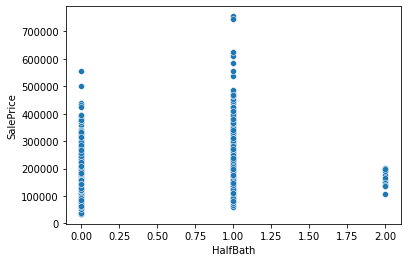

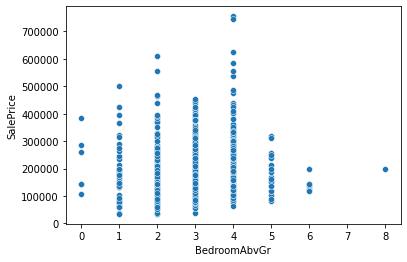

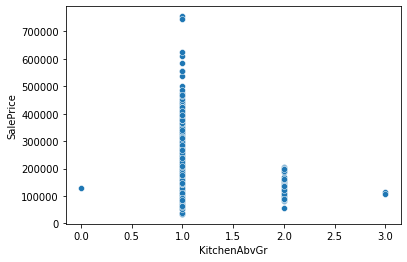

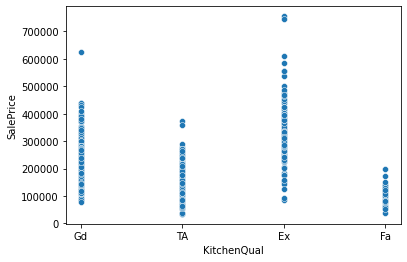

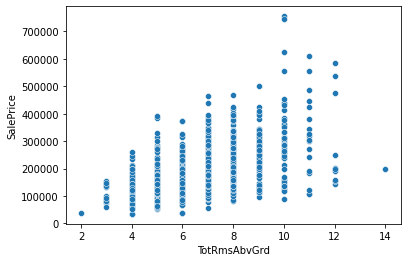

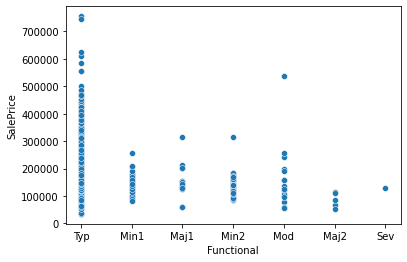

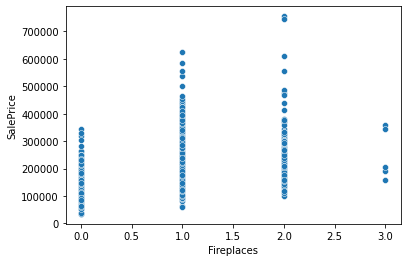

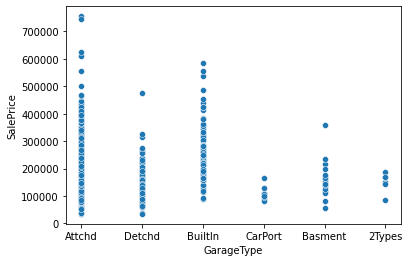

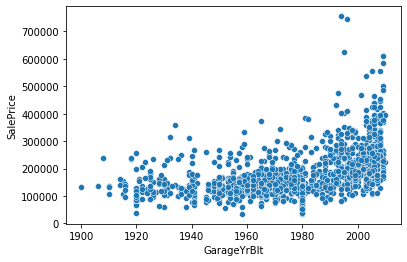

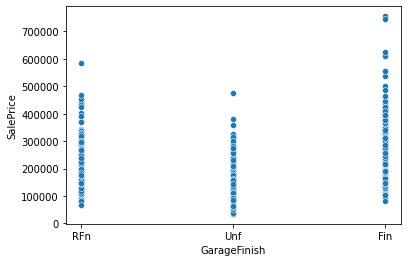

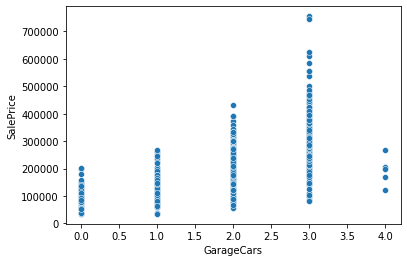

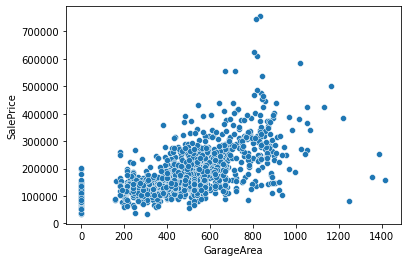

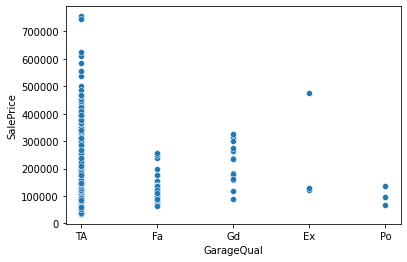

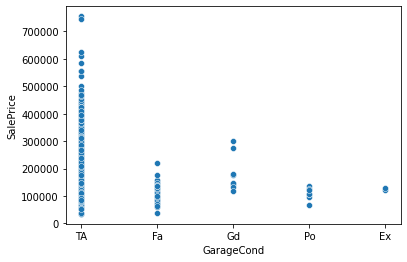

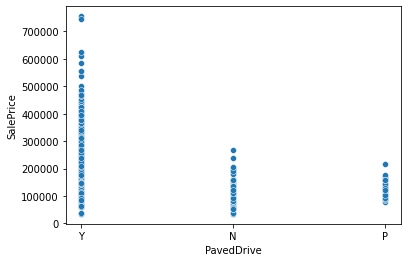

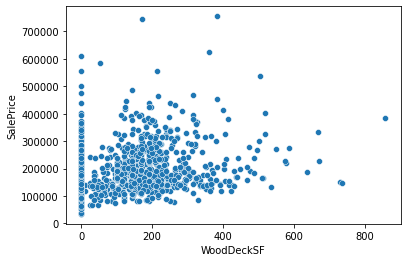

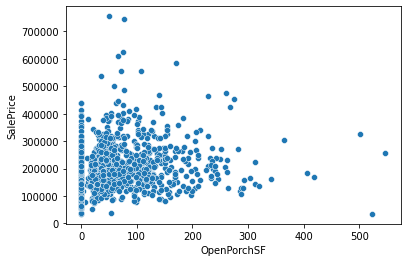

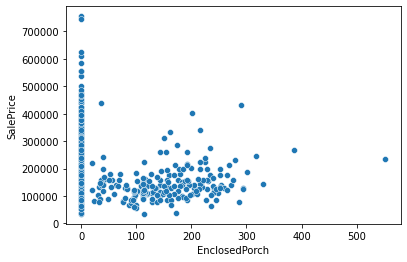

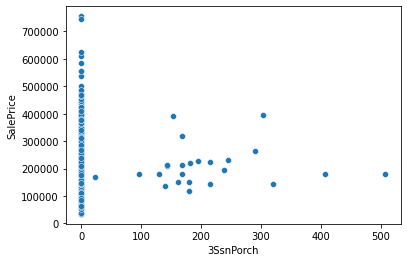

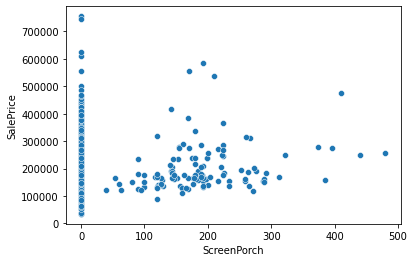

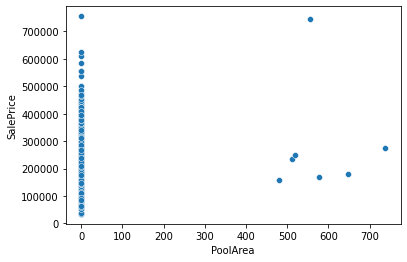

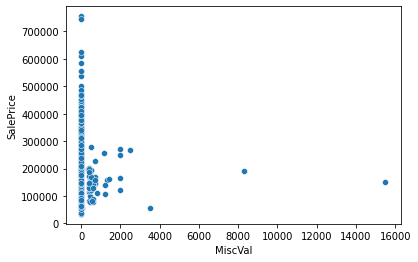

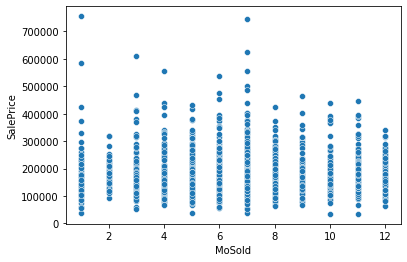

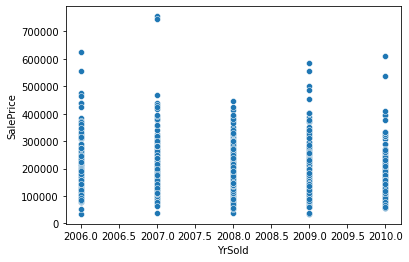

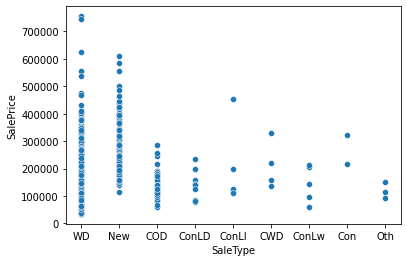

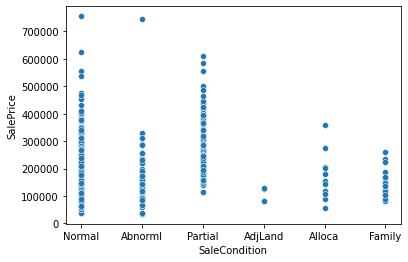

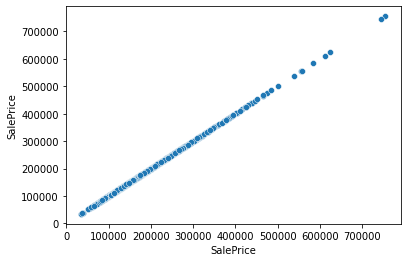

In [8]:
#Visualise all data
for col in training_col_list:
    sns.scatterplot(data=training,x=col,y="SalePrice")
    plt.show()

{0: 37, 1: 29, 2: 26, 3: 23, 4: 22, 5: 20, 6: 18, 7: 15, 8: 14, 9: 14, 10: 11, 11: 8, 12: 7, 13: 3, 14: 3, 15: 2, 16: 1, 17: 1, 18: 1, 19: 1}


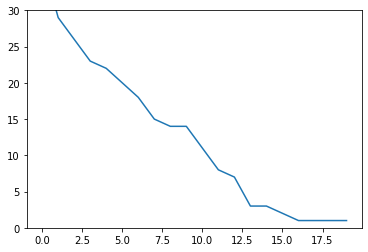

In [9]:
#Correlation of 0.55 gives 10 variables.
corrmat=training.corr()
corr_dict={}
for step in range(0,20,1):
    highest_corr_features_list=corrmat.index[abs(corrmat["SalePrice"])>step/20]
    corr_dict.update({step:len(highest_corr_features_list)})
print(corr_dict)
corr_dict_keys=list(corr_dict.keys())
corr_dict_values=list(corr_dict.values())
ax=sns.lineplot(data=corr_dict,x=corr_dict_keys,y=corr_dict_values)
ax.set(ylim=(0,30))
plt.show()

['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea', 'SalePrice']


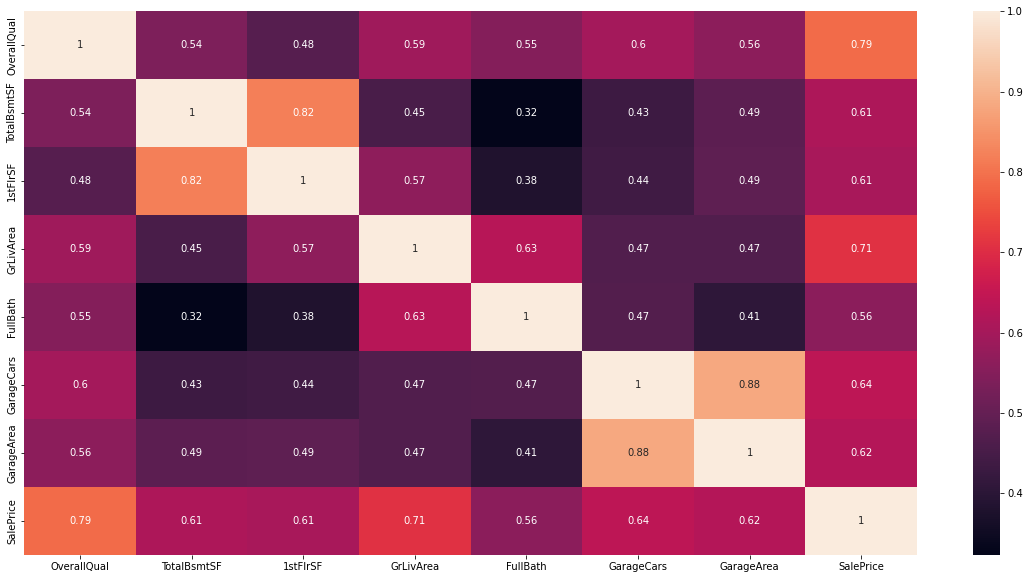

In [10]:
highest_corr_features_list=corrmat.index[abs(corrmat["SalePrice"])>0.55]
highest_corr_features_df=training[highest_corr_features_list]
plt.figure(figsize=(20,10))
g=sns.heatmap(highest_corr_features_df.corr(),annot=True)
highest_corr_features_df_columns_list=highest_corr_features_df.columns.tolist()
print(highest_corr_features_df_columns_list)

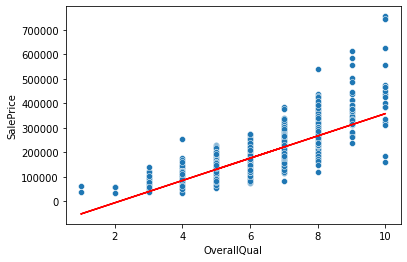

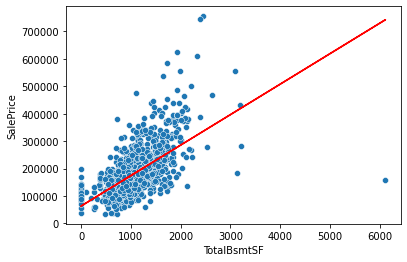

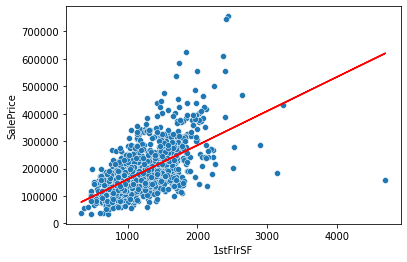

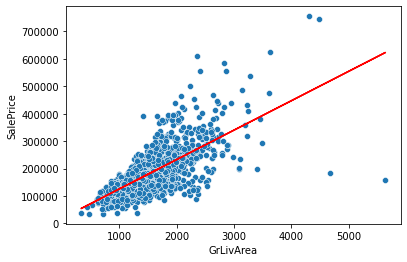

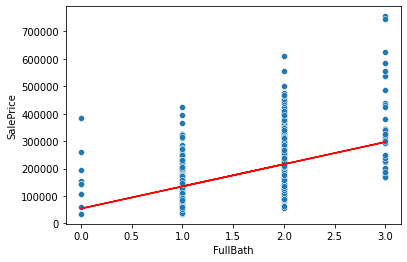

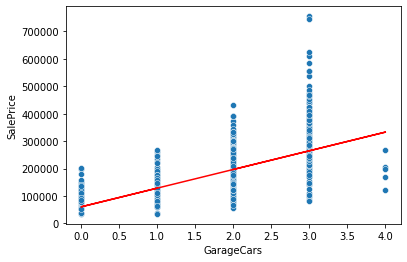

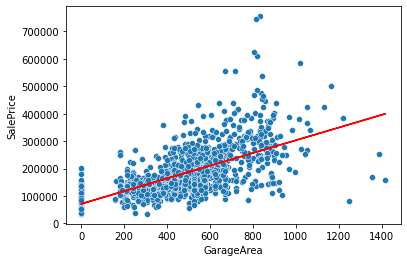

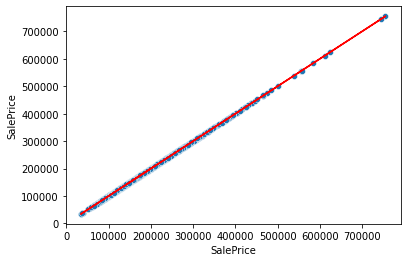

In [11]:
for f in highest_corr_features_list:
    sns.scatterplot(data=highest_corr_features_df,x=f,y="SalePrice")
    x=highest_corr_features_df[f]
    y=highest_corr_features_df["SalePrice"]
    m,b=np.polyfit(x,y,1)
    plt.plot(x,m*x+b,linestyle="-",color="red")
    plt.show()

In [12]:
#Filter training columns
#Replace get_dummies columns with original column.
training_modelling=training[highest_corr_features_df_columns_list]
training_modelling_variable=training_modelling.drop("SalePrice",axis=1)
training_modelling_target=training_modelling["SalePrice"]

In [13]:
#Add SalesPrice column to test
test["SalePrice"]=int(0)
#Modify Test columns to equal Train columns
test_modelling=test[highest_corr_features_df_columns_list]
print(training_modelling.head())
print(test_modelling.head())
print(test_modelling.shape)

   OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  GarageCars  \
0            7          856       856       1710         2           2   
1            6         1262      1262       1262         2           2   
2            7          920       920       1786         2           2   
3            7          756       961       1717         1           3   
4            8         1145      1145       2198         2           3   

   GarageArea  SalePrice  
0         548     208500  
1         460     181500  
2         608     223500  
3         642     140000  
4         836     250000  
   OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  GarageCars  \
0            5        882.0       896        896         1         1.0   
1            6       1329.0      1329       1329         1         1.0   
2            5        928.0       928       1629         2         2.0   
3            6        926.0       926       1604         2         2.0   
4            8       12

In [14]:
#Create Test model variable and target df
test_modelling_variable=test_modelling.drop("SalePrice",axis=1)
test_modelling_target=pd.DataFrame(test_modelling["SalePrice"])
print(test_modelling_variable.shape)
print(test_modelling_target.shape)

(1459, 7)
(1459, 1)


In [15]:
#Regression Model and parameters
'''algo_dict={LinearRegression:{"fit_intercept":[True,False],"normalize":[True,False]},\
           Lasso:{"alpha":[0.01,0.1,1,10,100],"fit_intercept":[True,False],"normalize":[True,False]},\
           SVR:{"kernel":["linear", "poly", "rbf", "sigmoid", "precomputed"],"degree":[1,2,3,4], "gamma":["scale","auto"],"C":[0.01,0.1,1,10,100]},\
           RandomForestRegressor:{"n_estimator":[1,10,100,1000],"criterion":["squared_error", "absolute_error", "poisson"]}}'''
lr=GridSearchCV(LinearRegression(),{"fit_intercept":[True,False],"normalize":[True,False]})
lasso=GridSearchCV(Lasso(),{"alpha":[0.01,0.1,1,10,100],"fit_intercept":[True,False],"normalize":[True,False]})
rr=GridSearchCV(Ridge(),{"alpha":[0.01,0.1,1,10,100],"fit_intercept":[True,False],"normalize":[True,False]})
knr=GridSearchCV(KNeighborsRegressor(),{"n_neighbors":[1,2,3,4,5],"weights":["uniform","distance"],\
                                        "algorithm":["auto","ball_tree","kd_tree","brute"]})
lr.fit(training_modelling_variable,training_modelling_target)
lasso.fit(training_modelling_variable,training_modelling_target)
rr.fit(training_modelling_variable,training_modelling_target)
knr.fit(training_modelling_variable,training_modelling_target)
print(lr.best_params_,lr.best_score_)
print(lasso.best_params_,lasso.best_score_)
print(rr.best_params_,rr.best_score_)
print(knr.best_params_,knr.best_score_)

{'fit_intercept': True, 'normalize': True} 0.7490138895647004
{'alpha': 10, 'fit_intercept': True, 'normalize': True} 0.7493091052244603
{'alpha': 0.1, 'fit_intercept': True, 'normalize': True} 0.7505042200769564
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'} 0.7166495936614423


In [16]:
#Use Ridge Regression
test_modelling_variable=impute_nans(test_modelling_variable,categorical_columns=[],\
                                    continuous_columns=['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', \
                                                        'GarageCars', 'GarageArea'])
test_modelling_target=rr.predict(test_modelling_variable)
print(test_modelling_target)

[119716.10943994 163106.35312537 161452.85835889 ... 153888.69420076
  92283.73583129 237432.66443333]


In [17]:
#Create submission file
submission_file=pd.DataFrame(test_modelling_target, columns=["SalePrice"])
submission_file["Id"]=test["Id"]
submission_file.set_index("Id",inplace=True)
print(submission_file)
submission_file.to_csv("submission_v2.0.csv",index=True)

          SalePrice
Id                 
1461  119716.109440
1462  163106.353125
1463  161452.858359
1464  181137.317199
1465  225461.857705
...             ...
2915   60961.640398
2916   81347.490482
2917  153888.694201
2918   92283.735831
2919  237432.664433

[1459 rows x 1 columns]
